# Chekhov GAN augmented MNIST

In [86]:
from __future__ import division, print_function, absolute_import

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [87]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [88]:
train_classifier = False # change to True if classifier not yet trained

if train_classifier:
    # Classifier parameters
    C_learning_rate = 0.01
    C_training_epochs = 200
    C_batch_size = 100
    C_display_step = 20

    # tf Graph Input
    x = tf.placeholder(tf.float32, [None, 784]) # mnist data image of shape 28*28=784
    y = tf.placeholder(tf.float32, [None, 10]) # 0-9 digits recognition => 10 classes

    # Set model weights
    W = tf.Variable(tf.zeros([784, 10]))
    b = tf.Variable(tf.zeros([10]))

    # Construct model
    C_pred = tf.nn.softmax(tf.matmul(x, W) + b) # Softmax

    # Minimize error using cross entropy
    C_cost = tf.reduce_mean(-tf.reduce_sum(y*tf.log(C_pred), reduction_indices=1)) 

    # Gradient Descent
    C_optimizer = tf.train.GradientDescentOptimizer(C_learning_rate).minimize(C_cost)
else:
    W = tf.get_variable("W", shape=[784,10])
    b = tf.get_variable("b", shape=[10])

ValueError: Variable W already exists, disallowed. Did you mean to set reuse=True in VarScope? Originally defined at:

  File "C:\Users\yujia21\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1264, in __init__
    self._traceback = _extract_stack()
  File "C:\Users\yujia21\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\yujia21\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 763, in apply_op
    op_def=op_def)


In [ ]:
# Training Params
num_steps = 70000
batch_size = 128
learning_rate = 0.0002
augmented_stack_size = 3

# Network Params
image_dim = 784*3 # 28*28 pixels * 3 images
gen_hidden_dim = 256*3
disc_hidden_dim = 256
noise_dim = 100*3 # Noise data points

# A custom initialization (see Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

In [ ]:
train_generator=False
# Store layers weight & bias
K = 10 #queue length
weights_list = []
biases_list = []
if train_generator:    
    weights_list += [{
        'gen_hidden1': tf.Variable(glorot_init([noise_dim, gen_hidden_dim])),
        'gen_out': tf.Variable(glorot_init([gen_hidden_dim, image_dim])),
        'disc_hidden1': tf.Variable(glorot_init([image_dim, disc_hidden_dim])),
        'disc_out': tf.Variable(glorot_init([disc_hidden_dim, 1])),
    },]

    biases_list += [{
        'gen_hidden1': tf.Variable(tf.zeros([gen_hidden_dim])),
        'gen_out': tf.Variable(tf.zeros([image_dim])),
        'disc_hidden1': tf.Variable(tf.zeros([disc_hidden_dim])),
        'disc_out': tf.Variable(tf.zeros([1])),
    },]
else:
    weights = {
        'gen_hidden1': tf.get_variable('gen_hidden1',shape=[noise_dim, gen_hidden_dim]),
        'gen_out': tf.get_variable('gen_out',shape=[gen_hidden_dim, image_dim]),
        'disc_hidden1': tf.get_variable('disc_hidden1',shape=[image_dim, disc_hidden_dim]),
        'disc_out': tf.get_variable('disc_out',shape=[disc_hidden_dim, 1])
    }
    
    biases={'gen_hidden1': tf.get_variable('b_gen_hidden1',shape=[gen_hidden_dim]),
        'gen_out': tf.get_variable('b_gen_out',shape=[image_dim]),
        'disc_hidden1': tf.get_variable('b_disc_hidden1',shape=[disc_hidden_dim]),
        'disc_out': tf.get_variable('b_disc_out',shape=[1])}
    weights_list=[weights]
    biases_list = [biases]

In [ ]:
# Generator
def generator_i(x,i):
    hidden_layer = tf.matmul(x, weights_list[i]['gen_hidden1'])
    hidden_layer = tf.add(hidden_layer, biases_list[i]['gen_hidden1'])
    hidden_layer = tf.nn.relu(hidden_layer)
    out_layer = tf.matmul(hidden_layer, weights_list[i]['gen_out'])
    out_layer = tf.add(out_layer, biases_list[i]['gen_out'])
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer

def generator(x):
    out_layer_sum=0
    for i in range(min(len(weights_list),K)): # if not yet K learners, just sum up to n_iter
        out_layer_sum+=generator_i(x,i)
    return out_layer_sum/min(len(weights_list),K)

# Discriminator
def discriminator_i(x,i):
    hidden_layer = tf.matmul(x, weights_list[i]['disc_hidden1'])
    hidden_layer = tf.add(hidden_layer, biases_list[i]['disc_hidden1'])
    hidden_layer = tf.nn.relu(hidden_layer)
    out_layer = tf.matmul(hidden_layer, weights_list[i]['disc_out'])
    out_layer = tf.add(out_layer, biases_list[i]['disc_out'])
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer

def discriminator(x):
    out_layer_sum=0
    for i in range(min(len(weights_list),K)):# if not yet K learners, just sum up to n_iter
        out_layer_sum+=discriminator_i(x,i)
    return out_layer_sum/min(len(weights_list),K)

# Build Networks
# Network Inputs
gen_input = tf.placeholder(tf.float32, shape=[None, noise_dim], name='input_noise')
disc_input = tf.placeholder(tf.float32, shape=[None, image_dim], name='disc_input')

# Build Generator Network
gen_sample = generator(gen_input)

# Build 2 Discriminator Networks (one from noise input, one from generated samples)
disc_real = discriminator(disc_input)
disc_fake = discriminator(gen_sample)

# Build Loss
gen_loss = -tf.reduce_mean(tf.log(disc_fake))
disc_loss = -tf.reduce_mean(tf.log(disc_real) + tf.log(1. - disc_fake))

# Build Optimizers
optimizer_gen = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=learning_rate)

# Training Variables for each optimizer
# By default in TensorFlow, all variables are updated by each optimizer, so we
# need to precise for each one of them the specific variables to update.
# Update last weights/biases in list
# Generator Network Variables
gen_vars = [weights_list[0]['gen_hidden1'], weights_list[0]['gen_out'],
            biases_list[0]['gen_hidden1'], biases_list[0]['gen_out']]
# Discriminator Network Variables
disc_vars = [weights_list[0]['disc_hidden1'], weights_list[0]['disc_out'],
            biases_list[0]['disc_hidden1'], biases_list[0]['disc_out']]

# Create training operations
train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [89]:
# Start Training
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(init)

In [90]:
if train_classifier:
    # Start classifier training
    for epoch in range(C_training_epochs):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/C_batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(C_batch_size)
            # Fit training using batch data
            _, c = sess.run([C_optimizer, C_cost], feed_dict={x: batch_xs,y: batch_ys})
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if (epoch+1) % C_display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))

    print("Optimization Finished!")

    # Test model
    correct_prediction = tf.equal(tf.argmax(C_pred, 1), tf.argmax(y, 1))
    # Calculate accuracy for test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    with sess.as_default():
        print("Accuracy:", accuracy.eval({x: mnist.test.images, y: mnist.test.labels}))

In [91]:
if train_classifier: #if training classifier, save weights
    C_saver = tf.train.Saver({'W':W,'b':b})
    C_saver.save(sess, "./saved/classifier_weights.ckpt")
else: #if training classifier, load weights
    C_saver = tf.train.Saver([W,b])
    C_saver.restore(sess, "./saved/classifier_weights.ckpt")

In [92]:
if train_generator:
    # Generator Training
    for i in range(1, num_steps+1):
        # Prepare Data
        # Augmented MNIST
        batch_x, _ = mnist.train.next_batch(augmented_stack_size*batch_size)
        batch_x = batch_x.reshape((batch_size,batch_x.shape[1]*augmented_stack_size))

    #     # Get the next batch of MNIST data (only images are needed, not labels)
    #     batch_x, _ = mnist.train.next_batch(batch_size)
    #     # Generate noise to feed to the generator
        z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])
        # Train
        feed_dict = {disc_input: batch_x, gen_input: z}
        _, _, gl, dl = sess.run([train_gen, train_disc, gen_loss, disc_loss],
                                    feed_dict=feed_dict)
        # Update weights/biases list
        # Update last item to be like second last    
        weights_list = [weights_list[0]] + weights_list
        biases_list = [biases_list[0]] + biases_list

        # Remove first item
        if len(weights_list) > K:
            weights_list.pop()
            biases_list.pop()

        if i % 7000 == 0 or i == 1:
            print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))

In [93]:
if train_generator:
    saver1 = tf.train.Saver(weights_list[0])
    saver1.save(sess, "./saved/chekhovgan_aug_weights.ckpt")
    saver2 = tf.train.Saver(biases_list[0])
    saver2.save(sess, "./saved/chekhovgan_aug_biases.ckpt")
else:
    saver1 = tf.train.Saver(weights)
    saver1.restore(sess, "./saved/chekhovgan_aug_weights.ckpt")
    saver2 = tf.train.Saver(biases)
    saver2.restore(sess, "./saved/chekhovgan_aug_biases.ckpt")

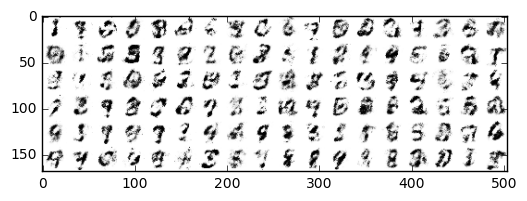

In [94]:
# Testing
# Generate images from noise, using the generator network.
n = 6
canvas = np.empty((28 * n, 28 * n * augmented_stack_size))
# Noise input.
z = np.random.uniform(-1., 1., size=[n*n, noise_dim])
# Generate image from noise.
g = sess.run(gen_sample, feed_dict={gen_input: z})
# Reverse colours for better display
g = -1 * (g - 1)

for k in range(augmented_stack_size):
    for i in range(n):
        for j in range(n):
            # Draw the generated digits
            canvas[i * 28:(i + 1) * 28, k*28*n + j * 28: k*28*n + (j + 1) * 28] = g[i*n+j,k*784:(k+1)*784].reshape([28, 28])

plt.figure(figsize=(n, n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()

In [95]:
# classify generated images
g = -1 * (g - 1)
y_plot = {}
y_plot_pred = np.zeros(n*n)
for k in range(augmented_stack_size):
    y_plot[k]= tf.nn.softmax(tf.matmul(g[:,k*784:(k+1)*784], W) + b).eval(session=sess)
    y_plot_pred += np.argmax(y_plot[k],1)*(10**k)

unique, counts = np.unique(y_plot_pred, return_counts=True)
d_plot = dict(zip(unique, counts))
y_plot_pred

array([ 261.,  287.,  900.,  360.,  478.,   56.,  888.,  481.,  522.,
        653.,  219.,  729.,  353.,  921.,  455.,  282.,  736.,  622.,
        277.,  653.,  229.,  538.,  390.,  280.,  549.,  823.,  547.,
        389.,  757.,  651.,  139.,  859.,  270.,  587.,  189.,  791.])

In [33]:
counts_test = dict.fromkeys(range(1000),0)

In [58]:
#run this cell 10 times, prevents hanging

n_test=10000
# Noise input.
z = np.random.uniform(-1., 1., size=[n_test, noise_dim])
# Generate image from noise.
g_test = sess.run(gen_sample, feed_dict={gen_input: z})

# classify generated images
y = {}
y_pred = np.zeros(n_test)
for k in range(augmented_stack_size):
    y[k] = tf.nn.softmax(tf.matmul(g_test[:,k*784:(k+1)*784], W) + b).eval(session=sess)
    y_pred += np.argmax(y[k],1)*10**k
    
unique, counts = np.unique(y_pred, return_counts=True)
for key,count in zip(unique, counts):
    counts_test[key]+=count
counts_test

{0: 48,
 1: 55,
 2: 142,
 3: 83,
 4: 83,
 5: 102,
 6: 55,
 7: 103,
 8: 113,
 9: 103,
 10: 18,
 11: 41,
 12: 77,
 13: 48,
 14: 26,
 15: 42,
 16: 58,
 17: 32,
 18: 94,
 19: 58,
 20: 82,
 21: 66,
 22: 182,
 23: 105,
 24: 108,
 25: 87,
 26: 148,
 27: 65,
 28: 162,
 29: 201,
 30: 47,
 31: 72,
 32: 119,
 33: 142,
 34: 77,
 35: 158,
 36: 41,
 37: 76,
 38: 99,
 39: 122,
 40: 76,
 41: 93,
 42: 192,
 43: 135,
 44: 72,
 45: 94,
 46: 108,
 47: 79,
 48: 156,
 49: 140,
 50: 92,
 51: 108,
 52: 211,
 53: 152,
 54: 84,
 55: 130,
 56: 53,
 57: 154,
 58: 132,
 59: 144,
 60: 72,
 61: 125,
 62: 237,
 63: 176,
 64: 154,
 65: 139,
 66: 151,
 67: 94,
 68: 210,
 69: 221,
 70: 54,
 71: 44,
 72: 199,
 73: 50,
 74: 37,
 75: 40,
 76: 40,
 77: 67,
 78: 110,
 79: 74,
 80: 89,
 81: 83,
 82: 130,
 83: 78,
 84: 98,
 85: 139,
 86: 61,
 87: 155,
 88: 82,
 89: 211,
 90: 36,
 91: 45,
 92: 80,
 93: 30,
 94: 54,
 95: 75,
 96: 40,
 97: 39,
 98: 97,
 99: 91,
 100: 65,
 101: 21,
 102: 169,
 103: 114,
 104: 38,
 105: 36,
 106: 3

In [59]:
sum(counts_test.values()) #check if it's total number of tests we want

100000

In [68]:
print(max(counts_test.values()))
print([key for key in counts_test.keys() if (counts_test[key]==max(counts_test.values()))])
print(min(counts_test.values()))
print([key for key in counts_test.keys() if (counts_test[key]==min(counts_test.values()))])

488
[257]
9
[191]


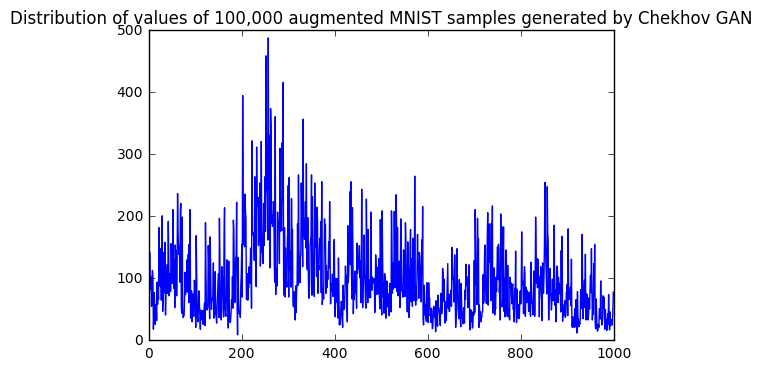

In [80]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(list(counts_test.keys()),list(counts_test.values()))
plt.title('Distribution of values of 100,000 augmented MNIST samples generated by Chekhov GAN')